Exploratory Data Analysis 

In [8]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_control_chart, plot_capability, plot_boxplot
from utilities_widgets import position_chart
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

In [9]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_")[0]
default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_")[0]
#fixture_data = consult_database("input.db", verbose=False, filter=file+"_fixture_data_")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

NameError: name 'fixture_data' is not defined

In [32]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "fixture_data" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(6, 5, 4), layout=Layout(width='600px'), options=('MID_GOLF_PA_li…

Table *VA_007_measurements_2024y_01m_09d_15h_53m_55s* retrieved succesfully.
Table *VA_007_limits_2024y_01m_09d_15h_53m_55s* retrieved succesfully.
Table *VA_007_fixture_data_2024y_01m_10d_8h_11m_10s* retrieved succesfully.


In [27]:
##Database management
print(f"File ready to add to the database:")
for table in tables.value:
    print(f"    {table}")

File ready to add to the database:
    MID_GOLF_PA_limits_2024y_01m_24d_10h_55m_14s
    MID_GOLF_PA_measurements_2024y_01m_24d_10h_55m_14s


In [28]:
##Data preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
display(MEAS_format)

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 21,test: 22,test: 23,test: 24,test: 25,test: 26,test: 27,test: 28,test: 29,test: 30
Guia_Luz_Blanco_FB1_X,0.3288,0.3273,0.3270,0.3278,0.3271,0.3268,0.3270,0.3276,0.3269,0.3267,...,0.3273,0.3272,0.3277,0.3272,0.3281,0.3272,0.3278,0.3282,0.3273,0.3273
Guia_Luz_Blanco_FB1_Y,0.3505,0.3497,0.3494,0.3501,0.3496,0.3492,0.3492,0.3500,0.3492,0.3493,...,0.3497,0.3497,0.3500,0.3498,0.3504,0.3497,0.3502,0.3503,0.3497,0.3498
Guia_Luz_Blanco_FB2_X,0.3295,0.3293,0.3290,0.3302,0.3293,0.3282,0.3286,0.3294,0.3283,0.3284,...,0.3290,0.3292,0.3286,0.3291,0.3295,0.3291,0.3295,0.3294,0.3289,0.3290
Guia_Luz_Blanco_FB2_Y,0.3510,0.3506,0.3504,0.3514,0.3506,0.3499,0.3502,0.3508,0.3500,0.3500,...,0.3505,0.3507,0.3502,0.3506,0.3509,0.3505,0.3509,0.3508,0.3504,0.3505
Guia_Luz_Blanco_FB3_X,0.3243,0.3238,0.3237,0.3237,0.3238,0.3237,0.3235,0.3242,0.3236,0.3238,...,0.3241,0.3240,0.3224,0.3241,0.3240,0.3240,0.3241,0.3240,0.3238,0.3240
Guia_Luz_Blanco_FB3_Y,0.3458,0.3450,0.3449,0.3448,0.3450,0.3449,0.3448,0.3453,0.3449,0.3450,...,0.3453,0.3451,0.3440,0.3453,0.3452,0.3452,0.3452,0.3452,0.3450,0.3452
Guia_Luz_Blanco_FB4_X,0.3284,0.3282,0.3282,0.3283,0.3280,0.3287,0.3285,0.3284,0.3277,0.3283,...,0.3292,0.3292,0.3290,0.3292,0.3291,0.3292,0.3290,0.3290,0.3289,0.3293
Guia_Luz_Blanco_FB4_Y,0.3512,0.3512,0.3512,0.3512,0.3510,0.3516,0.3514,0.3513,0.3507,0.3512,...,0.3520,0.3519,0.3519,0.3520,0.3520,0.3519,0.3519,0.3517,0.3517,0.3521
Guia_Luz_Blanco_FB5_X,0.3282,0.3287,0.3282,0.3282,0.3280,0.3283,0.3283,0.3284,0.3275,0.3280,...,0.3292,0.3292,0.3291,0.3297,0.3292,0.3293,0.3291,0.3290,0.3289,0.3293
Guia_Luz_Blanco_FB5_Y,0.3511,0.3515,0.3512,0.3512,0.3511,0.3513,0.3514,0.3514,0.3503,0.3508,...,0.3521,0.3520,0.3520,0.3524,0.3520,0.3521,0.3519,0.3518,0.3519,0.3520


In [29]:
##Limits review
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("limits:")
display(LIMITS_format)

limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.325,0.358


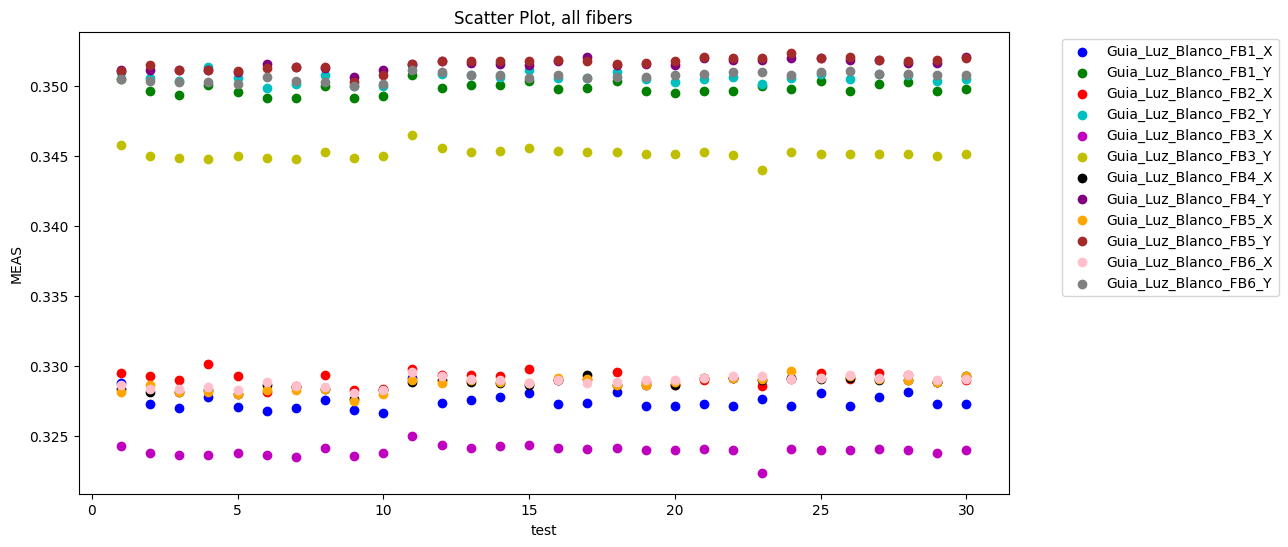

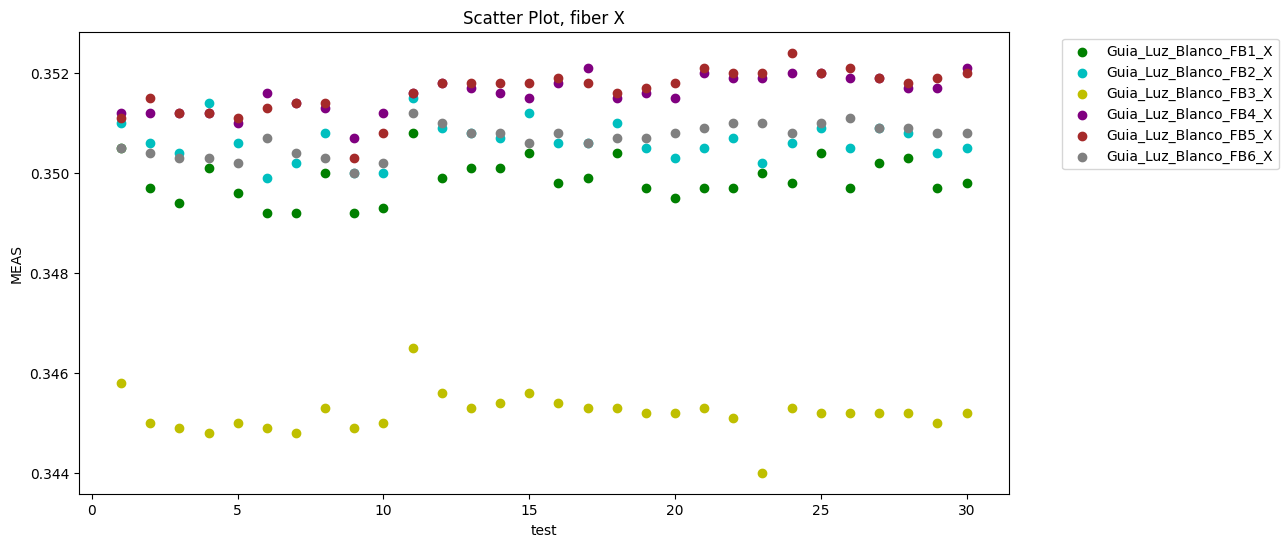

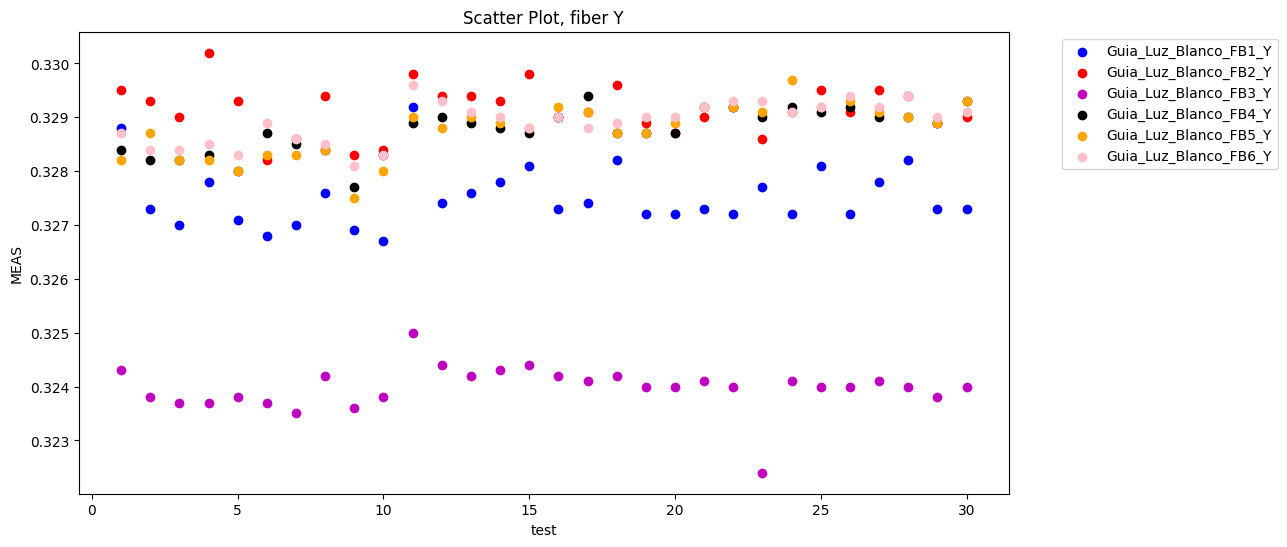

In [30]:
##Visualizations
plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [18]:
##Descriptive statistics
RESUME = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns.
RESUME_format = rename_index(RESUME)
display(RESUME_format)

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,30.0,0.316527,0.000503,0.3153,0.316300,0.31660,0.316850,0.3173
Guia_Luz_Blanco_FB1_Y,30.0,0.343353,0.000293,0.3426,0.343200,0.34340,0.343500,0.3438
Guia_Luz_Blanco_FB2_X,30.0,0.325937,0.001074,0.3243,0.324750,0.32635,0.326925,0.3274
Guia_Luz_Blanco_FB2_Y,30.0,0.351757,0.000556,0.3509,0.351200,0.35200,0.352200,0.3525
Guia_Luz_Blanco_FB3_X,30.0,0.322653,0.000185,0.3223,0.322525,0.32270,0.322775,0.3230
Guia_Luz_Blanco_FB3_Y,30.0,0.350140,0.000110,0.3500,0.350025,0.35015,0.350200,0.3504
Guia_Luz_Blanco_FB4_X,30.0,0.323500,0.001713,0.3197,0.322425,0.32310,0.324500,0.3286
Guia_Luz_Blanco_FB4_Y,30.0,0.346797,0.001040,0.3445,0.346125,0.34655,0.347475,0.3501
Guia_Luz_Blanco_FB5_X,30.0,0.328197,0.001119,0.3262,0.327700,0.32770,0.328000,0.3307
Guia_Luz_Blanco_FB5_Y,30.0,0.351667,0.000606,0.3502,0.351425,0.35150,0.351500,0.3529


Analysis of faulty fibers

In [22]:
##Analysis of faulty fibers
std = pd.DataFrame(RESUME_format['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Add an absolute number for quick identification
largest = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filter the 5 largest values
largest

,std,Fiber number
Guia_Luz_Blanco_FB4_X,0.001713,7
Guia_Luz_Blanco_FB10_X,0.001316,19
Guia_Luz_Blanco_FB5_X,0.001119,9
Guia_Luz_Blanco_FB2_X,0.001074,3
Guia_Luz_Blanco_FB11_X,0.001058,21


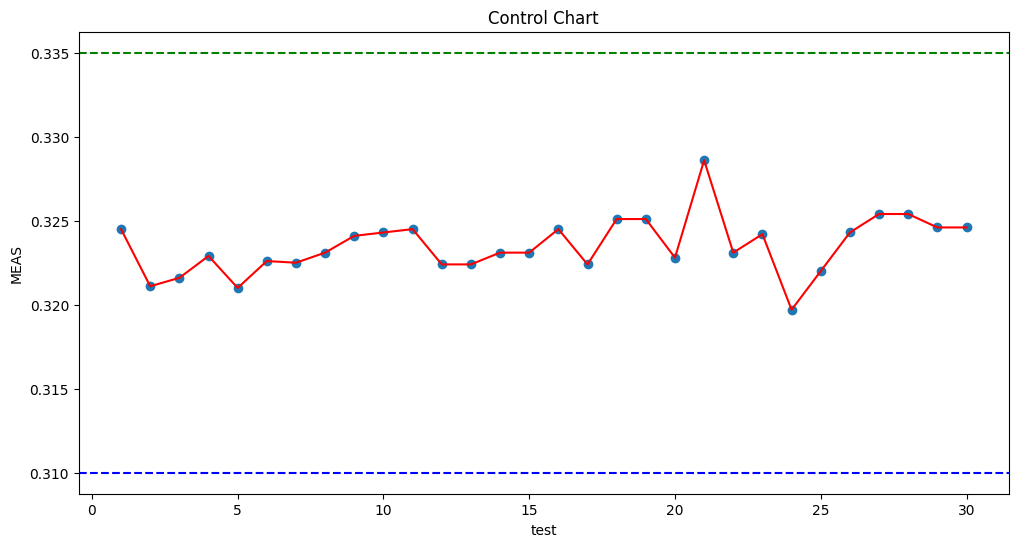

In [23]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_control_chart(MEAS_format, title='Control Chart', xlabel='test', ylabel='MEAS', LIMITS=LIMITS, fiber=fiber_selection.value, yrange=yrange)

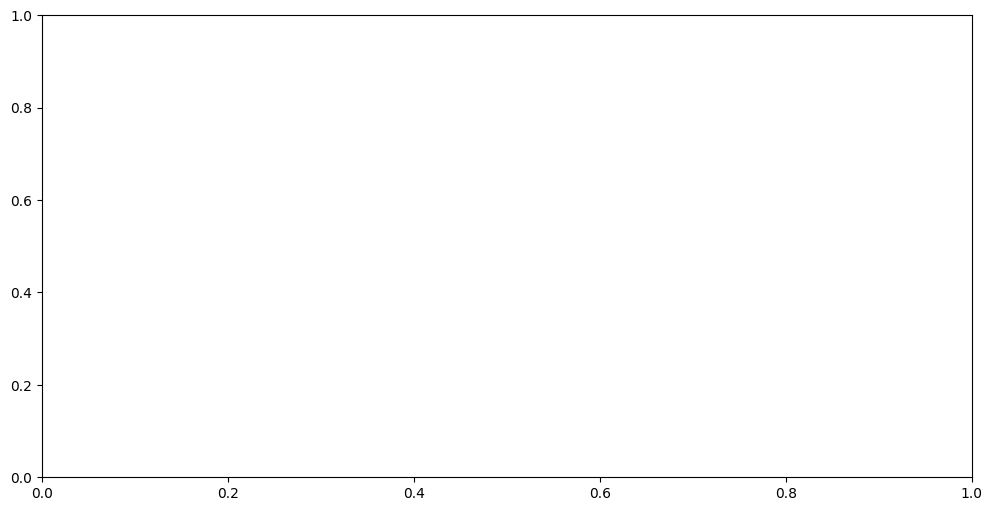

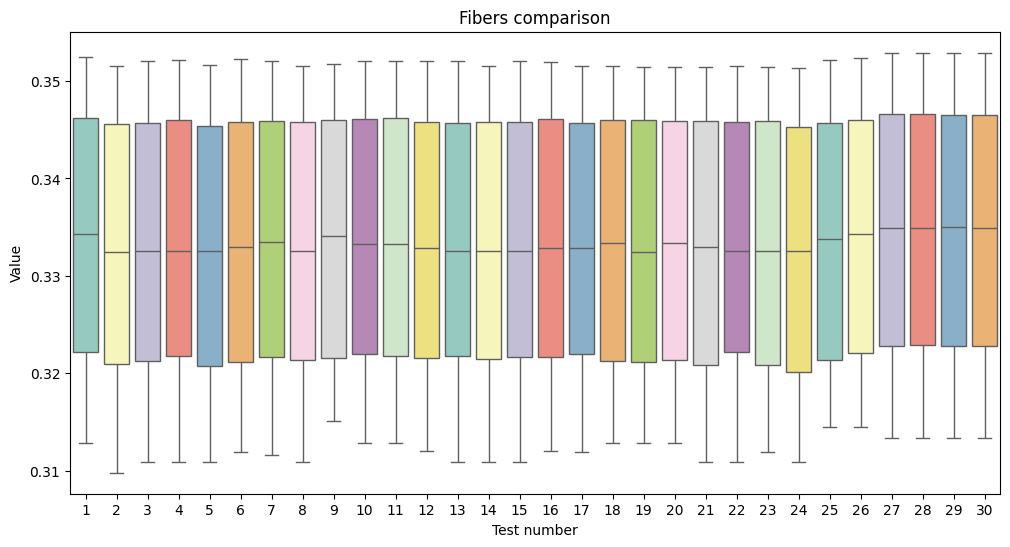

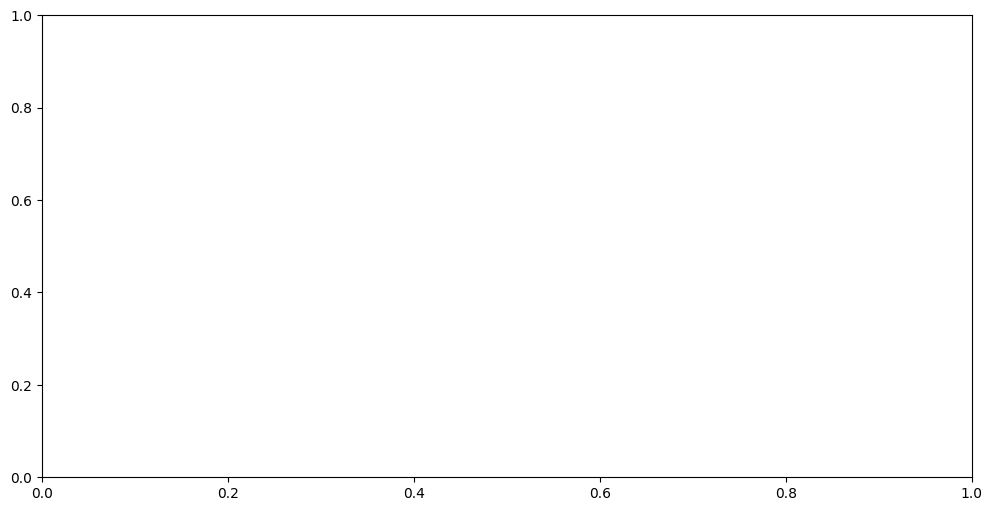

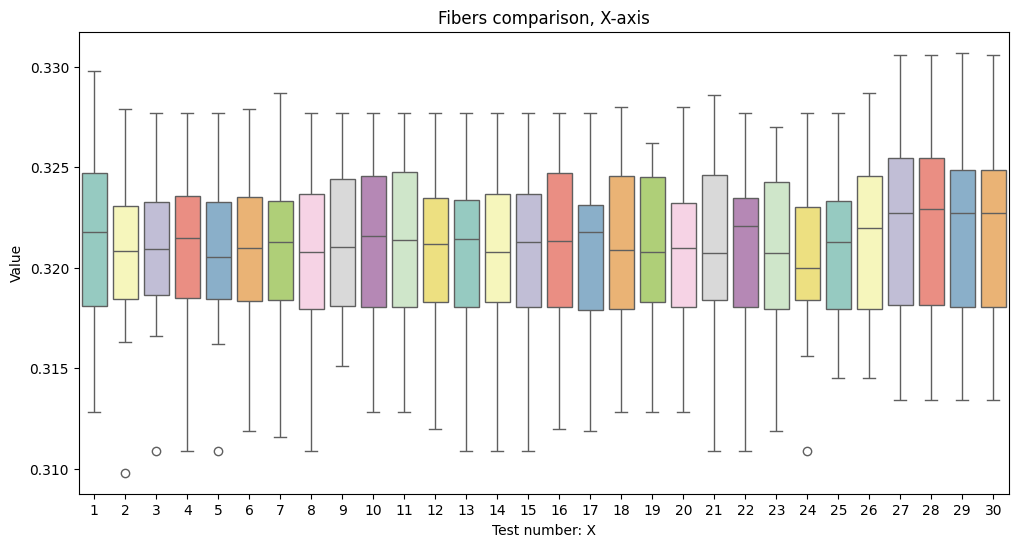

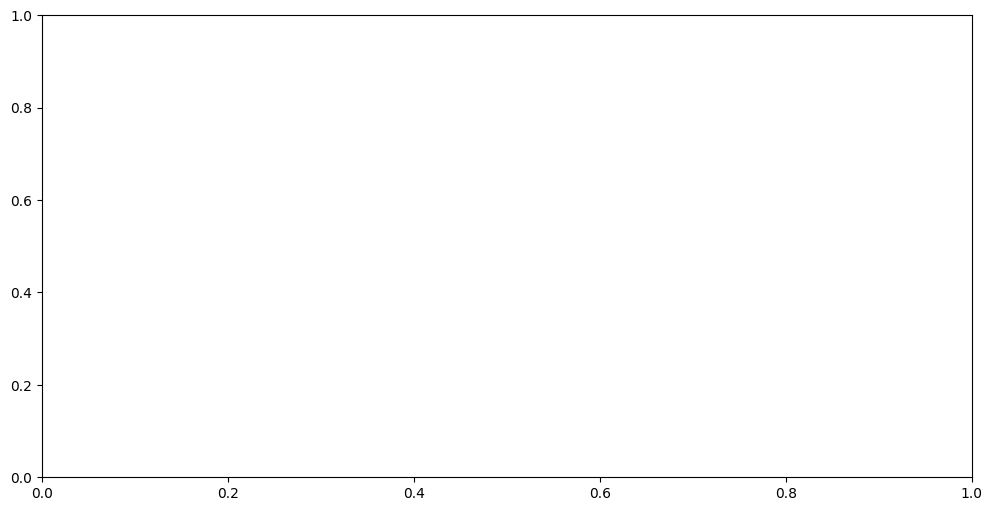

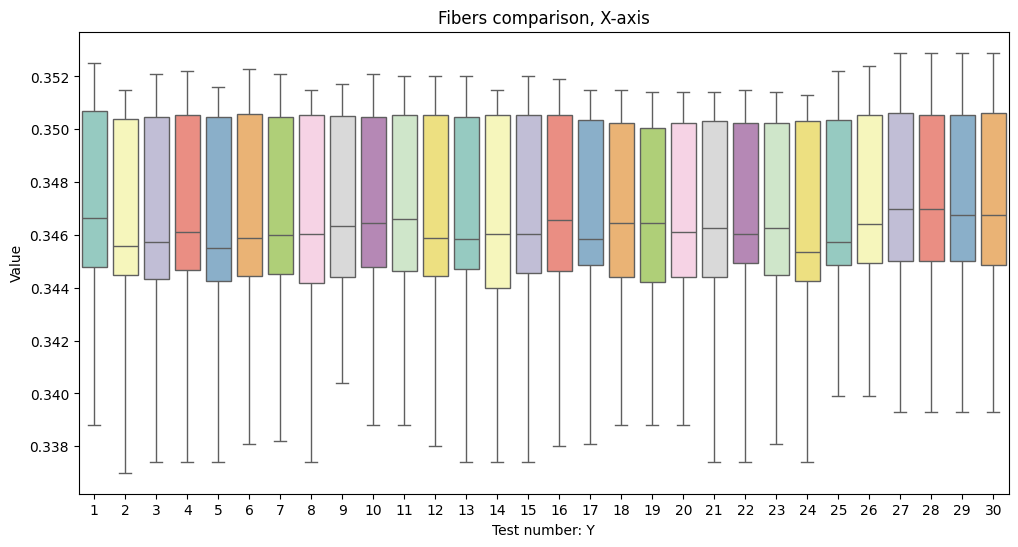

In [21]:
#Subgroups visualizations
plot_boxplot(MEAS_format, title="Fibers comparison", xlabel="Test number", ylabel="Value", filter=None)
plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="X")
plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="Y")

In [12]:
plot_boxplot(MEAS_format.transpose(), title="Fibers comparison", xlabel="Fibers group: ", ylabel="Value", filter="X", lenses_per_nest=FIXTURE_DATA.iloc["lenses per nest"])
plot_boxplot(MEAS_format.transpose(), title="Fibers comparison", xlabel="Fibers group: ", ylabel="Value", filter="Y", lenses_per_nest=glob.lenses_per_nest)

TypeError: Cannot index by location index with a non-integer key